# Target of the project

A 5-Year (2017-2021) Google stock price (GOOGL) history dataset has been downloaded from Yahoo Finance.<br>
This notebook will use Time Series Analysis to analyse and predict the stock price of the last month (Dec 2021).

## Import Packages

In [1]:
# Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pylab import rcParams

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, mean_squared_log_error

import pmdarima as pm
from itertools import product
from tqdm.notebook import tqdm

# Shows plots in jupyter notebook
%matplotlib inline
sns.set()

import warnings
warnings.filterwarnings('ignore')

## Load the dataset with Pandas
As we can see, there are 1259 entries and there is no null value.<br>
We are only intersted in the values in the "Close" column, as this will be our target variable.

In [2]:
df = pd.read_csv('./GOOGL.csv', parse_dates = ['Date'], index_col = 'Date')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-01-03 to 2021-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1259 non-null   float64
 1   High       1259 non-null   float64
 2   Low        1259 non-null   float64
 3   Close      1259 non-null   float64
 4   Adj Close  1259 non-null   float64
 5   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.9 KB


In [3]:
# Only keep the column 'Close' as this will be the target variable
df = df[['Close']]
df.head()

,Close
Date,
2017-01-03,808.010010
2017-01-04,807.770020
2017-01-05,813.020020
2017-01-06,825.210022
2017-01-09,827.179993


## Plot the data

We can see the data is not stationary and there is an incline trend.

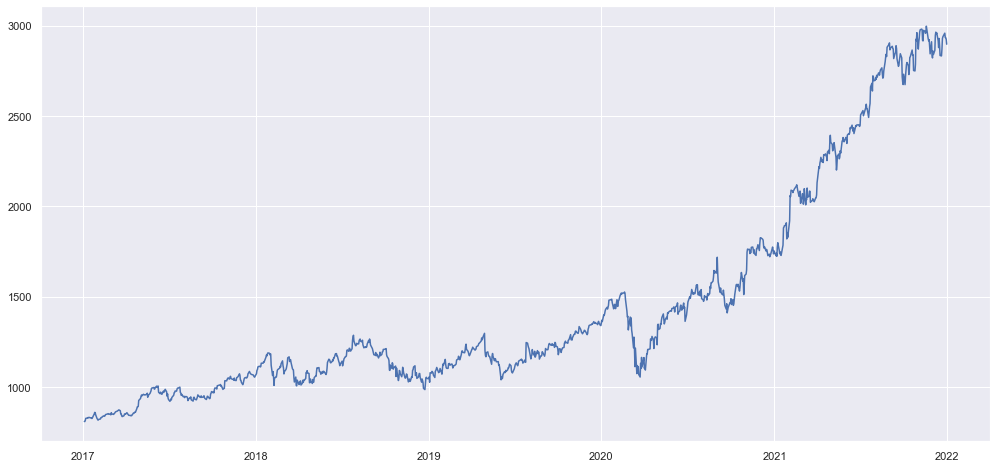

In [4]:
plt.figure(figsize=(17, 8))
plt.plot(df)
plt.show()

## Augmented Dicky-Fuller test
H0=Time series is non-stationary.<br>
From the result of Adfuller test, the p-value of 0.99 means the H0 can't be rejected.
Furthermore the increasing mean and standard deviation indicates that the time series data is not stationary and has a positive trend.

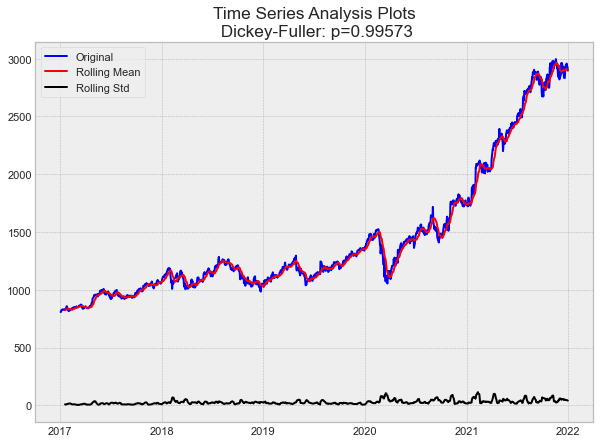

Results of Dickey-Fuller test:
Test Statistics                   1.164797
p-value                           0.995733
No. of lags used                 19.000000
Number of observations used    1239.000000
critical value (1%)              -3.435639
critical value (5%)              -2.863876
critical value (10%)             -2.568013
dtype: float64


In [5]:
def tsplot(y, figsize=(10, 7), syle='bmh'):
    
    # Ensure y is a Pandas Series data type
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    # Determine rolling statistics
    rolmean = y.rolling(12).mean()
    rolstd = y.rolling(12).std()
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        plt.plot(y, color='blue',label='Original')
        plt.plot(rolmean, color='red', label='Rolling Mean')
        plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        adf = adfuller(y)
        p_value = adf[1]
        plt.title(f'Time Series Analysis Plots\n Dickey-Fuller: p={p_value:.5f}')
        plt.show()
        
    print("Results of Dickey-Fuller test:")
    output = pd.Series(adf[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
   
    for key,values in adf[4].items():
        output['critical value (%s)'%key] =  values
        
    print(output)
        
tsplot(df.Close)

## Seasonal Decomposition
To separate the trend and the seasonality from a time series, we will decompose the series into the following: <br>
- Trend
- Seasonal 
- Residual

<Figure size 432x288 with 0 Axes>

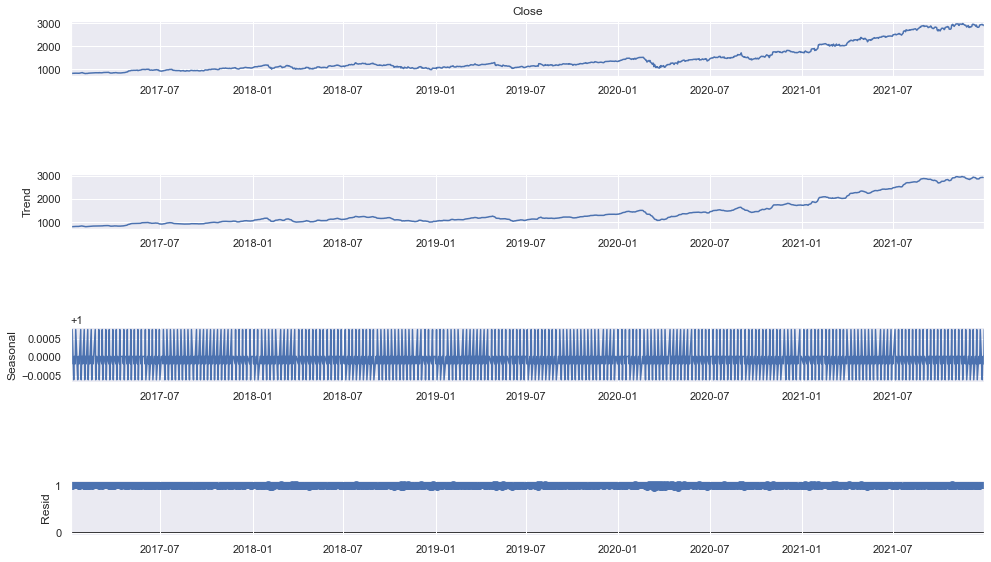

In [6]:
# Here the period is choosen as 5 
result = seasonal_decompose(df['Close'], model='multiplicative', period = 5)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)
plt.show()

## Transform the time series data

To reduce the magnitude of the values and the growing trend in the series, we first take a log of the series. We then calculate the rolling average of the series after obtaining the log of the series. A rolling average is computed by taking data from the previous 12 months and calculating a mean consumption value at each subsequent point in the series.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


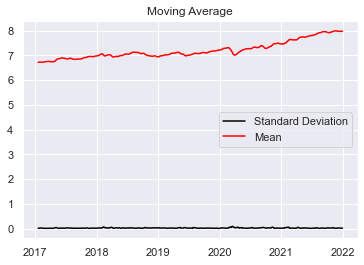

In [7]:
# rcParams['figure.figsize'] = 10, 6
df_log = np.log(df)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

## Train Test data split
As we will forecast the stock price of last month of 2021 (Dec), we will use ‘2021-12-01’ as the index to split data into training data and test data. The length of the test data is 22 as we are predicting the stock price of 22 days.

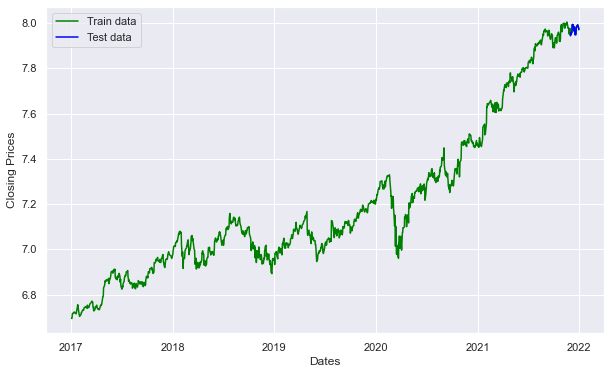

In [8]:
# Split data into train and training set
train_data, test_data = df_log[:'2021-12-01'], df_log['2021-12-01':]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()
plt.show()

## Model Selection
### AutoArima
Start with the simple ARIMA model without considering the seasonality. <br>
Use Auto Arima to find the best model which has the lowest AIC score.<br>
The result shows the best model is AR(1) with 1 step difference.

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6548.079, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6568.423, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6567.703, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6545.777, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6566.474, Time=0.63 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6566.467, Time=0.55 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6563.912, Time=0.84 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-6564.807, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 2.638 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1238
Model:               SARIMAX(1, 1, 0)   Log Likelihood                3287.211
Date:                Tue, 29 Mar 2022   AIC                          -6568.423
Time:                       

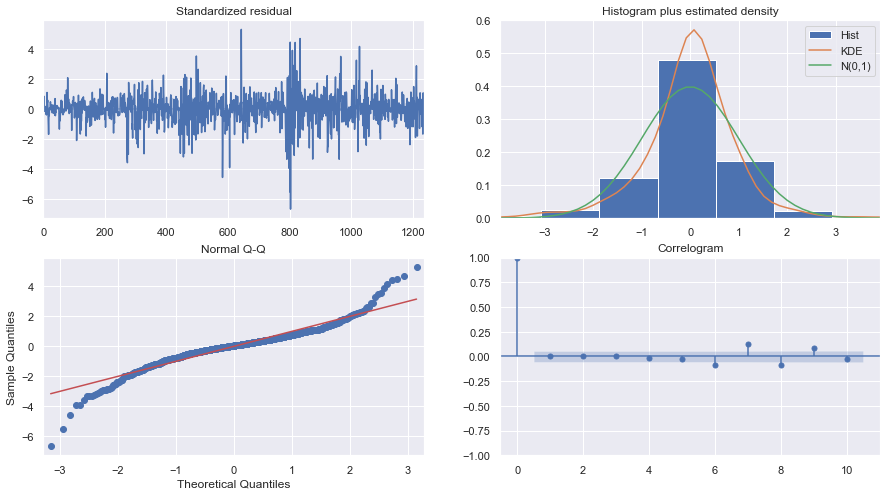

In [9]:
model_autoARIMA = pm.auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [10]:
# Modeling
# Fit the model with training data
model_ARIMA = ARIMA(train_data, order=(1,1,0))  
fitted_ARIMA = model_ARIMA.fit()  
print(fitted_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1238
Model:                 ARIMA(1, 1, 0)   Log Likelihood                3284.403
Date:                Tue, 29 Mar 2022   AIC                          -6564.807
Time:                        12:07:34   BIC                          -6554.566
Sample:                             0   HQIC                         -6560.955
                               - 1238                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1299      0.017     -7.556      0.000      -0.164      -0.096
sigma2         0.0003   6.36e-06     45.450      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.01   Jarque-

### Forecast


In [11]:
def get_predict_ci(fitted_model, steps, ci = 0.05):
    fc = fitted_model.get_forecast(steps, alpha = ci).predicted_mean 
    ci = fitted_model.get_forecast(steps, alpha = ci).conf_int()
    ci = ci.set_index(test_data.index)
    return(fc, ci)
fc, ci = get_predict_ci(fitted_ARIMA, 22)

In [12]:
def plot_forecast(fc, ci, train_data, test_data, zoom_in = False):
    
    # Use exponential to transform the log data back to the actual value
    fc_exp = pd.Series(np.exp(fc.values), index=test_data.index)
    lower_series_exp = np.exp(ci.iloc[:,0])
    upper_series_exp = np.exp(ci.iloc[:,1])
    
    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    if not zoom_in:
        plt.plot(np.exp(train_data), label='Training data')
    
    plt.plot(np.exp(test_data), color = 'blue', label='Actual Stock Price')
    plt.plot(fc_exp, color = 'orange',label='Predicted Stock Price')
    plt.fill_between(lower_series_exp.index, lower_series_exp, upper_series_exp, color='k', alpha=0.1)
    plt.title('GOOGLE Stock Price Prediction')
    plt.xlabel('Time')
    plt.tick_params(axis='x', labelrotation = 45)
    plt.ylabel('GOOGLE Stock Price')
    plt.legend(loc='upper left', fontsize=7)
    plt.show()

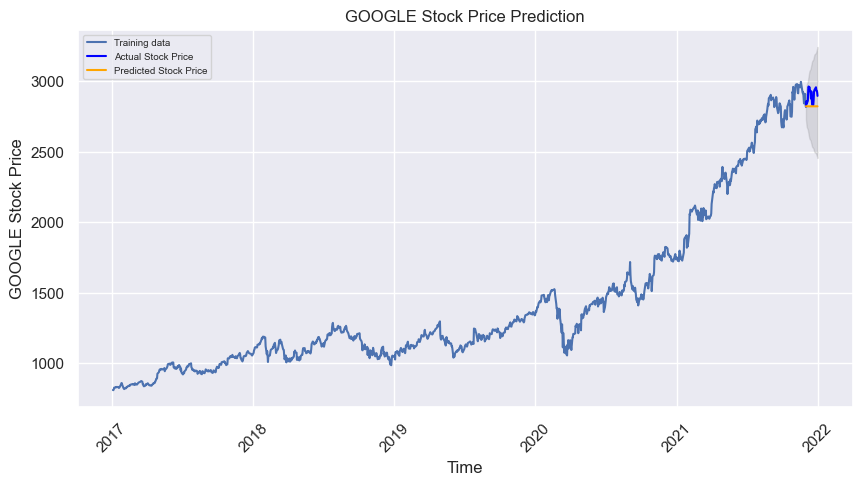

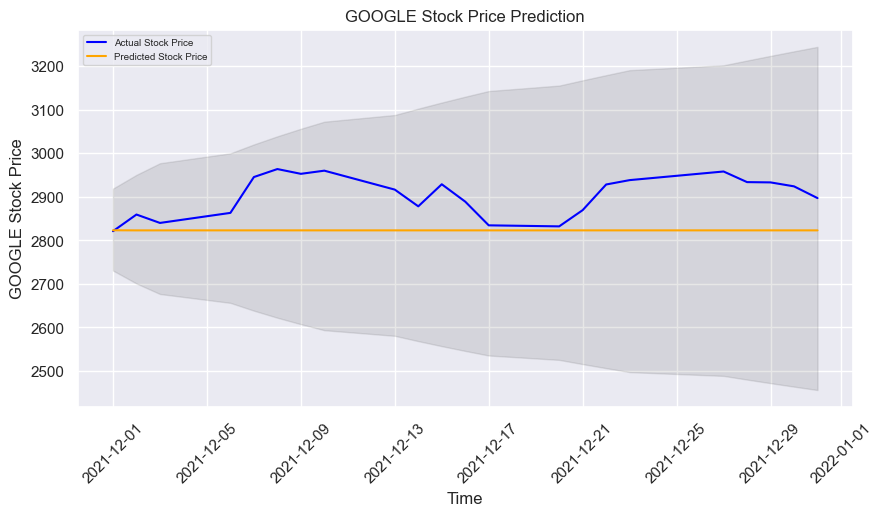

In [13]:
plot_forecast(fc, ci, train_data, test_data)
plot_forecast(fc, ci, train_data, test_data, zoom_in = True)

In [14]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [15]:
def report_performance(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    print('MSE: '+str(mse))
    mae = mean_absolute_error(y_true, y_pred)
    print('MAE: '+str(mae))
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print('RMSE: '+str(rmse))
    mape = mean_absolute_percentage_error(y_true.values, y_pred.values)
    print('MAPE: '+str(mape))

In [16]:
report_performance(test_data, fc)

MSE: 0.0010202197806570817
MAE: 0.027908195921448605
RMSE: 0.031940879459668635
MAPE: 0.34953755270059367


## SARIMAX 
### Model Parameter - Grid search


In [17]:
# Set initial values and some bounds
ps = range(0, 3)
d = 1
qs = range(0, 3)
Ps = range(0, 3)
D = 1
Qs = range(0, 3)
s = 5

# Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

In [18]:
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm(parameters_list):
        try: model = SARIMAX(train_data, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        # Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

  0%|          | 0/81 [00:00<?, ?it/s]

### Grid Search Result
From the Grid Search result we can see the best model is ARIMA (2,1,1) x (0,1,1)5



In [19]:
result_table

,parameters,aic
0,"(2, 1, 0, 1)",-6514.379428
1,"(2, 1, 1, 1)",-6514.317928
2,"(1, 2, 0, 1)",-6511.309323
3,"(1, 0, 0, 1)",-6511.187996
4,"(0, 1, 0, 1)",-6510.852505
...,...,...
76,"(1, 0, 0, 0)",-5665.823212
77,"(1, 2, 0, 0)",-5664.907441
78,"(2, 2, 0, 0)",-5664.396219
79,"(2, 1, 0, 0)",-5662.125314


In [20]:
p, q, P, Q = result_table.parameters[0]

fitted_SARIMAX = SARIMAX(train_data, order=(p, d, q),seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(fitted_SARIMAX.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                 1238
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 5)   Log Likelihood                3262.190
Date:                           Tue, 29 Mar 2022   AIC                          -6514.379
Time:                                   12:09:33   BIC                          -6488.797
Sample:                                        0   HQIC                         -6504.755
                                          - 1238                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0140      0.076    -13.283      0.000      -1.164      -0.864
ar.L2         -0.1519      0.017     -9.041

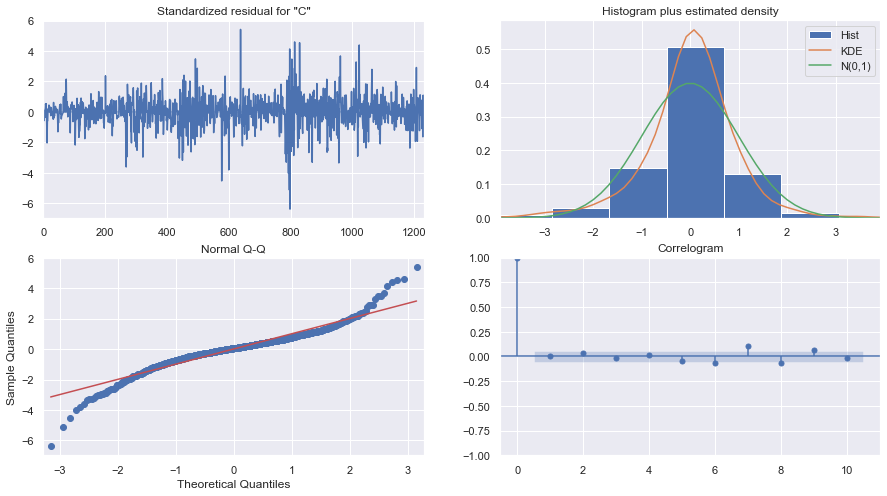

In [21]:
fitted_SARIMAX.plot_diagnostics(figsize=[15,8])
plt.show()

In [22]:
fc_SARIMAX, ci_SARIMAX = get_predict_ci(fitted_SARIMAX, 22)

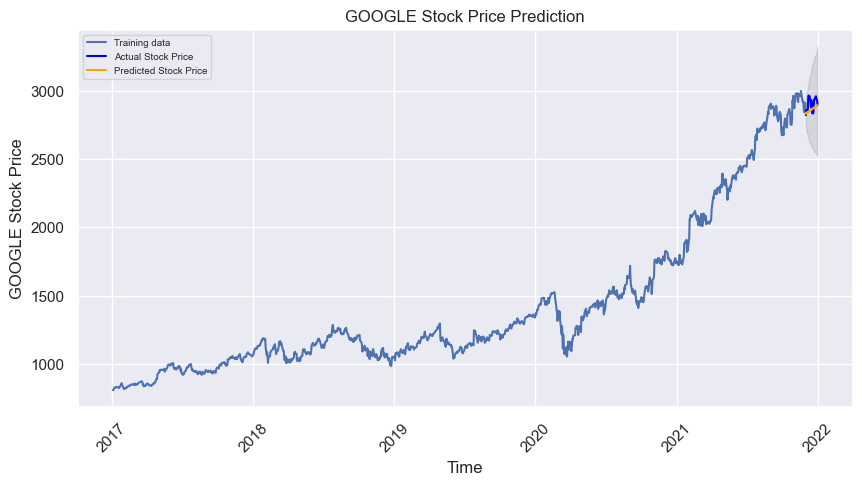

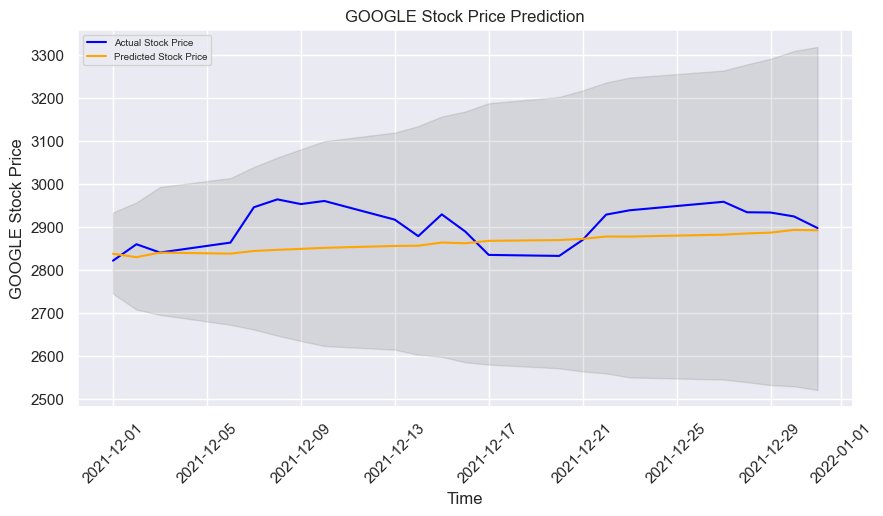

In [23]:
plot_forecast(fc_SARIMAX, ci_SARIMAX, train_data, test_data)
plot_forecast(fc_SARIMAX, ci_SARIMAX, train_data, test_data, zoom_in = True)

In [24]:
report_performance(test_data, fc_SARIMAX)

MSE: 0.00042335846567223524
MAE: 0.016870372923844634
RMSE: 0.02057567655442307
MAPE: 0.23474321002977697


## Performance Evaluation



The SARIMA(2,1,1)x(0,1,1)5 model perfomed with a MAPE of around 0.23, this mean it is 77% accurate in predicting the next 22 observations, which outperformed AR(1) by 16%.

